In [ ]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import pandas as pd
import os
from PIL import Image
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
import json

In [ ]:
train_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
valid_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=1,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               shuffle=False,
                                               seed=42)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [ ]:
from keras.applications import EfficientNetB0

input_shape = (224,224,3)
def build_model_efficientnet():
    efficientnet = EfficientNetB0(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape,
                        )
    model = Sequential([efficientnet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(256,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(128,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

model_efficientnet = build_model_efficientnet()
model_efficientnet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
tf.random.set_seed(42)

history_efficientnet = model_efficientnet.fit(train_data, epochs=8, steps_per_epoch=1024, validation_data=valid_data, validation_steps=1024)

Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725803819.873169     163 service.cc:145] XLA service 0x78bf9c039370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725803819.873234     163 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/1024 ━━━━━━━━━━━━━━━━━━━━ 25:30:50 90s/step - accuracy: 0.3750 - loss: 1.1882

I0000 00:00:1725803868.709445     163 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 829s 723ms/step - accuracy: 0.7853 - loss: 0.4807 - val_accuracy: 0.8976 - val_loss: 0.2492
Epoch 2/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 608s 595ms/step - accuracy: 0.9346 - loss: 0.1667 - val_accuracy: 0.9228 - val_loss: 0.1865
Epoch 3/8
   1/1024 ━━━━━━━━━━━━━━━━━━━━ 2:07 124ms/step - accuracy: 1.0000 - loss: 0.0342

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 610s 596ms/step - accuracy: 0.9481 - loss: 0.1317 - val_accuracy: 0.9404 - val_loss: 0.1527
Epoch 4/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 523s 511ms/step - accuracy: 0.9560 - loss: 0.1158 - val_accuracy: 0.9485 - val_loss: 0.1306
Epoch 5/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 199s 194ms/step - accuracy: 0.9614 - loss: 0.1033 - val_accuracy: 0.9550 - val_loss: 0.1145
Epoch 6/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 523s 508ms/step - accuracy: 0.9610 - loss: 0.1040 - val_accuracy: 0.9526 - val_loss: 0.1186
Epoch 7/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 571s 558ms/step - accuracy: 0.9669 - loss: 0.0881 - val_accuracy: 0.9643 - val_loss: 0.0995
Epoch 8/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 490s 479ms/step - accuracy: 0.9720 - loss: 0.0784 - val_accuracy: 0.9479 - val_loss: 0.1571


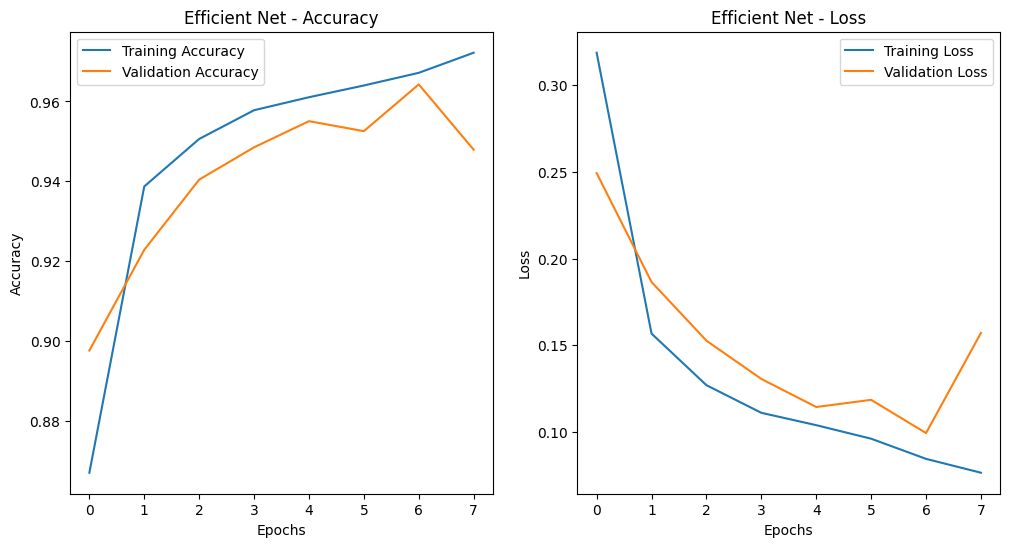

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, model_name):
    epochs = range(len(history.history['accuracy']))

    # Plotting Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example: Plot for InceptionV3
plot_accuracy_loss(history_efficientnet, 'Efficient Net')

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step


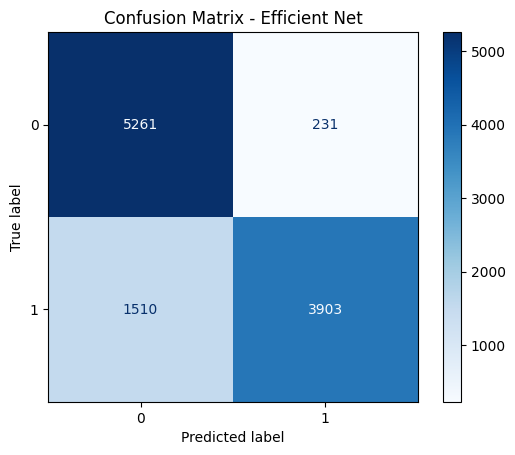

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have true labels and predicted labels from validation data
y_true = test_data.classes  # True labels
y_pred = model_efficientnet.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title('Confusion Matrix - Efficient Net')
plt.show()

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step


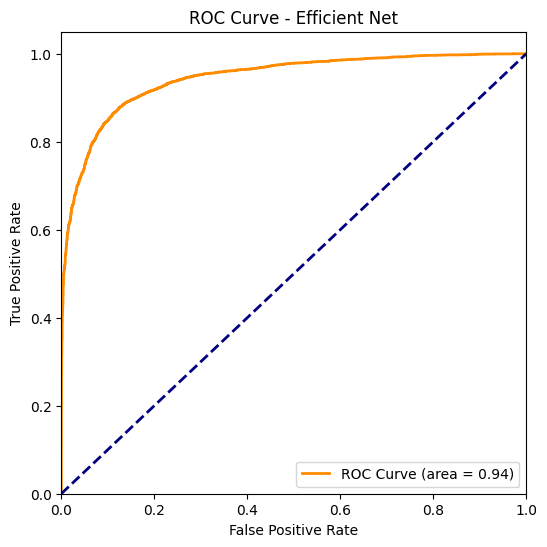

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_data, model_name):
    y_true = test_data.classes
    y_pred_proba = model.predict(test_data)  # Probabilities
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Example: Plot for InceptionV3
plot_roc_curve(model_efficientnet, test_data, 'Efficient Net')

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step


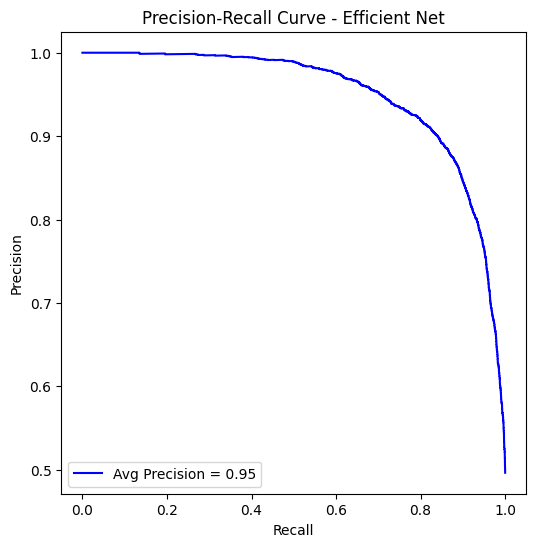

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(model, test_data, model_name):
    y_true = test_data.classes
    y_pred_proba = model.predict(test_data)  # Probabilities
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='b', label=f'Avg Precision = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.show()

# Example: Plot for InceptionV3
plot_precision_recall_curve(model_efficientnet, test_data, 'Efficient Net')

In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print('Classification Report - Efficient Net:')
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

Classification Report - Efficient Net:
              precision    recall  f1-score   support

     Class 0       0.78      0.96      0.86      5492
     Class 1       0.94      0.72      0.82      5413

    accuracy                           0.84     10905
   macro avg       0.86      0.84      0.84     10905
weighted avg       0.86      0.84      0.84     10905



In [ ]:
# Save the model to a file
model_save_path = "efficientnet_model.h5"
model_efficientnet.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to efficientnet_model.h5


Model loaded from /kaggle/working/efficientnet_model.h5


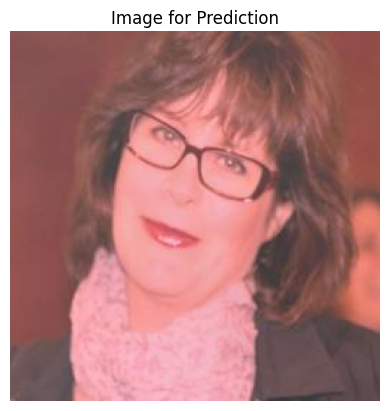

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Real


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the saved model
model_path = "/kaggle/working/efficientnet_model.h5"
model = load_model(model_path)
print(f"Model loaded from {model_path}")

# 2. Load and preprocess a new image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Path to the image you want to predict
image_path = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_17.jpg'
new_image = preprocess_image(image_path)

# Show the image
img = load_img(image_path)
plt.imshow(img)
plt.title("Image for Prediction")
plt.axis('off')
plt.show()

# 3. Predict the class of the new image
prediction = model.predict(new_image)

# 4. Output the prediction
if prediction[0] > 0.5:
    print("Predicted Class: Real")
else:
    print("Predicted Class: Fake")